# Word Embedding Classifier Pipeline

In [1]:
import os

import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import sklearn.neural_network
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from collections import OrderedDict

# Custom functions  
from utils import (
    print_gridsearch_results, 
    test_on_estimator, 
    plot_cv_train_test, 
    plot_cv_folds, 
    analysis_of_mistakes,
)

RANDOM_STATE = 123

## Data prep

In [2]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
y_train_df shape: (2400, 1) 


In [3]:
output_dir = 'embedding_predictions'

## Dataset Exploration

In [4]:
num_train_samples = x_train_text.shape[0]
num_positive_train_samples = np.count_nonzero(y_train == 1)
fraction_positive_train = float(num_positive_train_samples) / float(num_train_samples)


print(f"Total number of training samples = {num_train_samples}")
print(f"Fraction positive training samples = {fraction_positive_train}")


Total number of training samples = 2400
Fraction positive training samples = 0.5


## Word Embedding

In [5]:
zip_file_path = os.path.join(
    'pretrained_embedding_vectors/',
    'glove.6B.50d.txt.zip')

word_embeddings = pd.read_csv(
    zip_file_path,
    header=None, sep=' ', index_col=0,
    nrows=100000, compression='zip', encoding='utf-8', quoting=3)

# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

In [6]:
import re

x_train_embeddings = np.zeros((num_train_samples, 50))

unique_vocab_words = set()

for ind in range(num_train_samples):
    sample = x_train_text[ind]
    stripped_sample = re.sub(r'[^\w\s]', '', sample).lower()
    sample_embedding = []
    #print(f"Current sample = {stripped_sample}")
    for word in stripped_sample.split(' '):
        if word in word2vec.keys() and word not in text.ENGLISH_STOP_WORDS:
            sample_embedding.append(word2vec[word])
            unique_vocab_words.add(word)
            
    if len(sample_embedding) == 0:
        sample_embedding = [0] * 50
        
    sample_embedding = np.array(sample_embedding)
    avg_sample_embedding = np.nanmean(sample_embedding, axis=0)
    x_train_embeddings[ind] = avg_sample_embedding

In [7]:
# Size of vocab set
len(unique_vocab_words)

3902

## Load test set for predictions

In [8]:
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))

# Get the text as a list of strings
x_test_text = x_test_df['text'].values
num_test_samples = x_test_text.shape[0]

In [9]:
x_test_embeddings = np.zeros((num_test_samples, 50))

for ind in range(num_test_samples):
    sample = x_test_text[ind]
    stripped_sample = re.sub(r'[^\w\s]', '', sample).lower()
    sample_embedding = []
    #print(f"Current sample = {stripped_sample}")
    for word in stripped_sample.split(' '):
        if word in word2vec.keys() and word not in text.ENGLISH_STOP_WORDS:
            sample_embedding.append(word2vec[word])
            unique_vocab_words.add(word)
            
    if len(sample_embedding) == 0:
        sample_embedding = [0] * 50
        
    sample_embedding = np.array(sample_embedding)
    avg_sample_embedding = np.nanmean(sample_embedding, axis=0)
    x_test_embeddings[ind] = avg_sample_embedding

## Stable CV splitter  

In [10]:
cv_splitter = sklearn.model_selection.StratifiedKFold(n_splits=5)

## Hyperparameter searcher: Random Forest classifier

In [9]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
# Random Forest hyperparameter grid
rf_parameters = {
    "rf__max_depth": np.linspace(1, 15, 5).astype(int),
    "rf__n_estimators": np.linspace(1,200,5).astype(int),
}
rf_pipeline_tuple = ('rf', rf_classifier)
print(rf_parameters)

{'rf__max_depth': array([ 1,  4,  8, 11, 15]), 'rf__n_estimators': array([  1,  50, 100, 150, 200])}


In [11]:
embedding_rf_pipeline = Pipeline([
#     embedding_pipeline_tuple,
    rf_pipeline_tuple,
 ])
embedding_rf_full_grid = { 
    **rf_parameters
}


embedding_rf_grid_searcher = GridSearchCV(
    embedding_rf_pipeline, 
    embedding_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=4,  
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
embedding_rf_grid_searcher.fit(x_train_embeddings, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   48.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'rf__max_depth': array([ 1,  4,  8, 11, 15]),
                         'rf__n_estimators': array([  1,  50, 100, 150, 200])},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [12]:
print_gridsearch_results(embedding_rf_grid_searcher, list(embedding_rf_full_grid.keys()))

Dataframe has shape: (25, 22)
Number of trials used in grid search:  25


,param_rf__max_depth,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
19,11,200,0.993125,0.751667,3.971049,1
24,15,200,0.996354,0.751250,3.381581,2
18,11,150,0.993437,0.750833,3.000432,3
17,11,100,0.992708,0.747917,1.645861,4
23,15,150,0.996354,0.746250,2.787339,5
12,8,100,0.960833,0.745833,1.432667,6
22,15,100,0.996354,0.744583,2.148737,7
11,8,50,0.955521,0.742917,0.669140,8
14,8,200,0.963438,0.742500,2.825635,9
13,8,150,0.962083,0.740833,2.100476,10


In [13]:
embedding_rf_grid_searcher.best_params_

{'rf__max_depth': 11, 'rf__n_estimators': 200}

In [14]:
embedding_rf_grid_searcher.cv_results_

{'mean_fit_time': array([0.00783992, 0.24913659, 0.5157053 , 0.86296377, 1.28903723,
        0.01788001, 0.75943794, 1.04013381, 1.39965248, 1.89036808,
        0.01564045, 0.66914043, 1.4326674 , 2.10047617, 2.82563505,
        0.01843524, 0.86393466, 1.6458611 , 3.00043182, 3.97104917,
        0.03116341, 0.95790486, 2.14873667, 2.78733897, 3.38158078]),
 'std_fit_time': array([0.00184978, 0.01441229, 0.04399008, 0.10747266, 0.10202933,
        0.00517005, 0.08315472, 0.1213042 , 0.10609579, 0.03664479,
        0.00252775, 0.04225509, 0.04321488, 0.03266807, 0.09467674,
        0.00207996, 0.01993691, 0.04358878, 0.11286744, 0.08083102,
        0.01566803, 0.08682026, 0.17089338, 0.04509297, 0.25079374]),
 'mean_score_time': array([0.0029726 , 0.0123086 , 0.02787857, 0.06669569, 0.07538447,
        0.00718102, 0.0375268 , 0.02863722, 0.03520279, 0.04605684,
        0.00280666, 0.01463556, 0.03159924, 0.04063215, 0.05440679,
        0.0027689 , 0.0194304 , 0.03212428, 0.07225933, 0.05

In [66]:
embedding_rf_filename = os.path.join(output_dir, 'emb_rf_yproba1_test.txt')
test_on_estimator(embedding_rf_grid_searcher.best_estimator_, x_test_embeddings, embedding_rf_filename)

## Hyperparameter searcher: Gradient Boosted Tree classifier

In [15]:
gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=RANDOM_STATE)
# GradientBoosting-Tree hyperparameter grid
gbtree_parameters = {
    "gbtree__n_estimators": [100, 200, 300],
    "gbtree__max_depth": [5, 10, 20],
    "gbtree__min_samples_leaf": [1, 3, 5],
}
gbtree_pipeline_tuple = ('gbtree', gbtree_classifier)

In [16]:
embedding_gbtree_pipeline = Pipeline([
#     tf_pipeline_tuple,
    gbtree_pipeline_tuple,
 ])
embedding_gbtree_full_grid = { 
#     **tf_parameters,
    **gbtree_parameters
}


embedding_gbtree_grid_searcher = GridSearchCV(
    embedding_gbtree_pipeline, 
    embedding_gbtree_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
embedding_gbtree_grid_searcher.fit(x_train_embeddings, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 21.2min
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed: 23.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('gbtree',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   random_state=123))]),
             n_jobs=3,
             param_grid={'gbtree__max_depth': [5, 10, 20],
                         'gbtree__min_samples_leaf': [1, 3, 5],
                         'gbtree__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [17]:
print_gridsearch_results(embedding_gbtree_grid_searcher, list(embedding_gbtree_full_grid.keys()))

Dataframe has shape: (27, 23)
Number of trials used in grid search:  27


,param_gbtree__n_estimators,param_gbtree__max_depth,param_gbtree__min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
4,200,5,3,0.996354,0.753333,28.033063,1
2,300,5,1,0.996354,0.751250,43.464620,2
5,300,5,3,0.996354,0.751250,39.437778,3
7,200,5,5,0.996354,0.749167,22.476392,4
6,100,5,5,0.995313,0.747917,11.528823,5
17,300,10,5,0.996354,0.747917,41.072321,5
16,200,10,5,0.996354,0.746667,35.086122,7
26,300,20,5,0.996354,0.745833,35.255301,8
1,200,5,1,0.996354,0.745000,29.182798,9
3,100,5,3,0.995729,0.745000,13.359479,10


In [18]:
embedding_gbtree_grid_searcher.best_params_

{'gbtree__max_depth': 5,
 'gbtree__min_samples_leaf': 3,
 'gbtree__n_estimators': 200}

In [67]:
embedding_gbtree_filename = os.path.join(output_dir, 'emb_gbtree_yproba1_test.txt')
test_on_estimator(embedding_gbtree_grid_searcher.best_estimator_, x_test_embeddings, embedding_gbtree_filename)

## Hyperparameter Search: L1-Logistic Regression

In [19]:
lasso = sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE)
# logit_lasso hyperparameter grid
lasso_parameters = {
     'lasso__C': np.logspace(-3, 3, 7),
     'lasso__max_iter': [20, 40, 60], # sneaky way to do "early stopping" 
}
lasso_pipeline_tuple = ('lasso', lasso)


In [20]:
embedding_lasso_pipeline = Pipeline([
    lasso_pipeline_tuple,
 ])
embedding_lasso_full_grid = { 
    **lasso_parameters
}


embedding_lasso_grid_searcher = GridSearchCV(
    embedding_lasso_pipeline, 
    embedding_lasso_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
embedding_lasso_grid_searcher.fit(x_train_embeddings, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  85 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done 105 out of 105 | elapsed:    2.7s finished
/Users/moose/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('lasso',
                                        LogisticRegression(penalty='l1',
                                                           random_state=123,
                                                           solver='saga'))]),
             n_jobs=3,
             param_grid={'lasso__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lasso__max_iter': [20, 40, 60]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [21]:
print_gridsearch_results(embedding_lasso_grid_searcher, list(embedding_lasso_full_grid.keys()))

Dataframe has shape: (21, 22)
Number of trials used in grid search:  21


,param_lasso__C,param_lasso__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
10,1,40,0.770625,0.757083,0.093070,1
17,100,60,0.769479,0.756667,0.145226,2
18,1000,20,0.768854,0.756667,0.052000,3
16,100,40,0.769896,0.756667,0.101625,3
15,100,20,0.768750,0.756667,0.048301,3
13,10,40,0.770104,0.756667,0.103908,3
12,10,20,0.769167,0.756667,0.049382,3
11,1,60,0.770937,0.756667,0.135521,3
19,1000,40,0.769896,0.756667,0.097136,3
14,10,60,0.769583,0.756250,0.146920,10


In [22]:
embedding_lasso_grid_searcher.best_params_

{'lasso__C': 1.0, 'lasso__max_iter': 40}

# MLP Classifier

In [11]:
mlp = sklearn.neural_network.MLPClassifier(solver='lbfgs', random_state=RANDOM_STATE)
mlp_parameters = {
    'mlp__hidden_layer_sizes': [16, 32, 64],
    'mlp__alpha': [0.0001,0.01,1, 10],
    'mlp__max_iter': [50, 100, 200, 500], # sneaky way to do "early stopping" 
}
mlp_pipeline_tuple = ('mlp', mlp)

In [12]:
embedding_mlp_pipeline = Pipeline([
#     tf_pipeline_tuple,
    mlp_pipeline_tuple,
 ])
embedding_mlp_full_grid = { 
#     **tf_parameters,
    **mlp_parameters
}


embedding_mlp_grid_searcher = GridSearchCV(
    embedding_mlp_pipeline, 
    embedding_mlp_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
embedding_mlp_grid_searcher.fit(x_train_embeddings, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   17.8s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:  2.7min finished
/Users/moose/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('mlp',
                                        MLPClassifier(random_state=123,
                                                      solver='lbfgs'))]),
             n_jobs=3,
             param_grid={'mlp__alpha': [0.0001, 0.01, 1, 10],
                         'mlp__hidden_layer_sizes': [16, 32, 64],
                         'mlp__max_iter': [50, 100, 200, 500]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [13]:
print_gridsearch_results(embedding_mlp_grid_searcher, list(embedding_mlp_full_grid.keys()))

Dataframe has shape: (48, 23)
Number of trials used in grid search:  48


,param_mlp__hidden_layer_sizes,param_mlp__alpha,param_mlp__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
37,16,10,100,0.804479,0.761250,0.351655,1
38,16,10,200,0.813438,0.757917,0.661384,2
46,64,10,200,0.826771,0.756250,1.756300,3
47,64,10,500,0.834792,0.755000,4.266096,4
44,64,10,50,0.801771,0.755000,0.474778,5
40,32,10,50,0.796042,0.754167,0.284882,6
39,16,10,500,0.818750,0.753750,1.637326,7
36,16,10,50,0.790000,0.753750,0.189260,7
45,64,10,100,0.817396,0.752917,0.895919,9
42,32,10,200,0.818542,0.752500,1.023344,10


In [14]:
# Plotting the CV results for a gridsearch over one feature
cv_results = embedding_mlp_grid_searcher.cv_results_
cv_results

{'mean_fit_time': array([0.39233398, 0.85272956, 1.58124065, 4.10223503, 0.52393689,
        1.37150464, 1.9635478 , 3.84191656, 1.14566927, 1.80362964,
        3.7334692 , 4.47487202, 0.36261239, 0.64593606, 1.14911051,
        2.635255  , 0.45754714, 0.88017225, 1.93955154, 5.72439585,
        1.01930408, 1.70529728, 3.42315545, 8.93013968, 0.44301085,
        0.80102258, 1.398908  , 2.56897616, 0.49894814, 0.72047734,
        1.60339727, 3.97907147, 0.79804831, 1.3392035 , 2.9430243 ,
        5.5512301 , 0.1892601 , 0.3516552 , 0.66138415, 1.6373261 ,
        0.28488216, 0.5375802 , 1.02334356, 2.48480959, 0.47477822,
        0.89591918, 1.75629969, 4.26609616]),
 'std_fit_time': array([0.08077334, 0.26557566, 0.45463242, 0.56751109, 0.06505576,
        0.1743594 , 0.10817558, 0.24098089, 0.53685281, 0.35345875,
        0.379522  , 0.38288586, 0.08205786, 0.08352565, 0.11598425,
        0.10700622, 0.09158697, 0.08756102, 0.21945929, 0.3463939 ,
        0.14784618, 0.15516254, 0.226

In [15]:
embedding_mlp_filename = os.path.join(output_dir, 'emb_mlp_yproba1_test.txt')
test_on_estimator(embedding_mlp_grid_searcher.best_estimator_, x_test_embeddings, embedding_mlp_filename)

In [59]:

def plot_cv_folds(cv_results, param_name, param_label, folds, log10=False, log2=False):
    _, ax = plt.subplots(1, 1)

    # Get averages
    mean_test_score = cv_results['mean_test_score']
    mean_train_score = cv_results['mean_train_score']

    # Get x_values
    param_values = cv_results[f'param_{param_name}']
    x_values = param_values.data.astype(np.float64)
    if (log10):
        x_values = np.log10(x_values)
    elif (log2):
        x_values = np.log2(x_values)

    ax.plot(x_values, mean_test_score, '-bs', label=f'average test')
    ax.plot(x_values, mean_train_score, '-rs', label=f'average train')

    # Get overall mean_train_score
    for fold in range(folds):
        fold_scores = cv_results[f'split{fold}_test_score']
        ax.plot(x_values, fold_scores, 's', label=f'{fold}-validation set')

    ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(param_label, fontsize=16)
    ax.set_ylabel('Balanced Accuracy', fontsize=16)
    ax.legend(loc="best", fontsize=15, bbox_to_anchor=(1, 1))

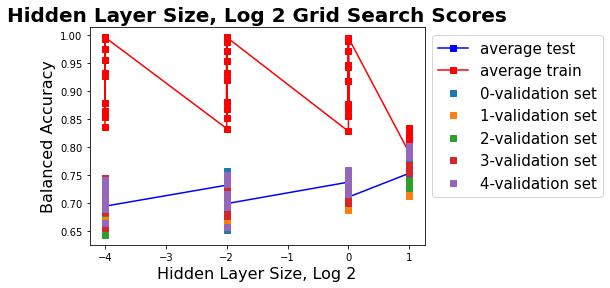

In [61]:
# Plotting the CV results for a gridsearch over one feature

cv_results = embedding_mlp_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(mlp_parameters.keys())[1]
param_label = "Hidden Layer Size, Log 2"

plot_cv_folds(cv_results, param, param_label, 5, log10=True)

In [16]:
embedding_mlp_best_pipeline = embedding_mlp_grid_searcher.best_estimator_
analysis_of_mistakes(embedding_mlp_best_pipeline, x_train_df, y_train)

ValueError: could not convert string to float: 'Oh and I forgot to also mention the weird color effect it has on your phone.'

In [58]:

# train_split_scores_columns = ['split0_train_score','split1_train_score','split2_train_score','split3_train_score','split4_train_score']
# test_split_scores_columns = ['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']

# hidden_layers16_df = embedding_df[embedding_df['param_mlp__hidden_layer_sizes'] == 16]
# hidden_layers16_df_50iters = hidden_layers16_df[hidden_layers16_df['param_mlp__max_iter'] == 50]
# hidden_layers16_df_50iters

In [57]:
# import matplotlib.pyplot as plt

# alpha_values = [0.0001,0.01,1, 10]
# y_split0_test = hidden_layers16_df_50iters['split0_test_score'].values
# y_split1_test = hidden_layers16_df_50iters['split1_test_score'].values
# y_split2_test = hidden_layers16_df_50iters['split2_test_score'].values
# y_split3_test = hidden_layers16_df_50iters['split3_test_score'].values
# y_split4_test = hidden_layers16_df_50iters['split4_test_score'].values

# plt.plot(alpha_values, y_split0_test, linewidth=1)
# plt.plot(alpha_values, y_split1_test, linewidth=1)
# plt.plot(alpha_values, y_split2_test, linewidth=1)
# plt.plot(alpha_values, y_split3_test, linewidth=1)
# plt.plot(alpha_values, y_split4_test, linewidth=1)

# plt.xticks(alpha_values)
# plt.xlabel('Alpha Values')
# plt.ylabel('Balanced Accuracy scores')
# #display plot
# plt.show()